This notebook contains a series of data cube queries and loads, allowing the user to time various applications in the DEA sandbox. For each test, we aim to provide a reference point, so the user may assess performance.

## Import necessary modules

In [2]:
import datacube
import timeit
import numpy as np
import pandas as pd

# Define the datacube object for future use
dc = datacube.Datacube()

## Define functions for timing searches and loads

The `timeit` module that we'll be using to benchmark searches and loads works by calling a predefined functions. Here, we define functions in terms of the key search parameters: `product`, `lat`, `lon` and `time`.

In [11]:
# Perform a seach (without loading) on latitude, longitude and time
def find_latlontime(product, lat, lon, time):
    return dc.find_datasets(product=product, latitude=lat, longitude=lon, time=time)

# Perfom a search (without loading) on latitude and longitude
def find_latlon(product, lat, lon):
    return dc.find_datasets(product=product, latitude=lat, longitude=lon)

# Perfom a search (without loading) on time
def find_time(product, time):
    return dc.find_datasets(product=product, time=time)

# fc_percentile_albers_annual

Whole colection summary
* 28,687 datasets
* 9,251,834km$^2$
* Annual data product from 1987 to 2017

For this search, we define our reference coordinates from [Tile +14, -41](https://dashboard.dea-sandbox.test.frontiersi.io/region/fc_percentile_albers_annual/14_-41).

For this benchmark, we time how long it takes to load all of the available data in a given area. We search over all available time. We increase the area for each test by increasing the latitude and longitude bounds by a fixed amount `delta_latlon`. The timing process will take a few minutes, so please be patient.

In [13]:
product = 'fc_percentile_albers_annual'

ref_lat = -36.0
ref_lon = 148.0

delta_latlon = 0.5 #amount to scale lat and lon by
delta_latlon_list = [i*delta_latlon for i in range(10)]

# define dictionary and array to store time taken and amount of data found
search_time = {}
n_data = []

for delta in delta_latlon_list:
    print('Timing search for delta =', delta)
    lat_search = [ref_lat, ref_lat + delta]
    lon_search = [ref_lon, ref_lon + delta]
    
    search_time[delta] = np.asarray(timeit.repeat('find_latlon(product=product, lat=lat_search, lon=lon_search)',
                                                  setup = 'from __main__ import find_latlon, product, lat_search, lon_search',
                                                  repeat=7, number=3))/3
    n_data.append(len(find_latlon(product=product, lat=lat_search, lon=lon_search)))
print('Timing complete!')

# calculate the average time taken for each instance
average_time = [np.mean(search_time[delta]) for delta in delta_latlon_list]    

Timing search for delta = 0.0
Timing search for delta = 0.5
Timing search for delta = 1.0
Timing search for delta = 1.5
Timing search for delta = 2.0
Timing search for delta = 2.5
Timing search for delta = 3.0
Timing search for delta = 3.5
Timing search for delta = 4.0
Timing search for delta = 4.5
Timing complete!


### Save the current run as the benchmark

The cell below allows you to overwrite the default benchmark. We recommend that you save the benchmark to a new file in case you want to keep the existing benchmark as a reference.

In [14]:
# OPTION TO SAVE MOST RECENT RUN AS THE NEW BENCHMARK
# benchmark = {'Number of datasets': n_data,
#              'Additional area covered (degrees^2)': np.asarray(delta_latlon_list)**2,
#              'Time taken (s)': average_time}

# benchmark_df = pd.DataFrame(benchmark,
#                             columns = ['Number of datasets',
#                                        'Additional area covered (degrees^2)',
#                                        'Time taken (s)'])

# benchmark_file = 'benchmarks/fc_percentile_albers_annual_search_benchmark.csv'
# benchmark_df.to_csv(benchmark_file, index=False)

### Benchmark plots

The following cell plots the amount of time to run the search in terms of the number of datasets found as well as the area the search covers in degrees$^2$. The existing benchmark is also plotted as a reference point.

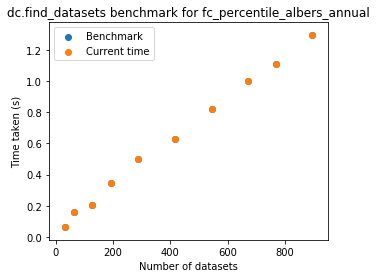

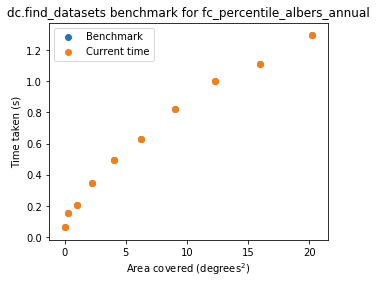

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load the existing benchmark
existing_benchmark_file = 'benchmarks/fc_percentile_albers_annual_search_benchmark.csv'
existing_benchmark = pd.read_csv(existing_benchmark_file, index_col=None)

# Plot time vs. number of data sets
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)
ax.scatter(existing_benchmark['Number of datasets'], existing_benchmark['Time taken (s)'], label="Benchmark")
ax.scatter(n_data, average_time, label='Current time')
ax.set_ylabel('Time taken (s)')
ax.set_xlabel('Number of datasets')
ax.set_title('dc.find_datasets benchmark for fc_percentile_albers_annual')
ax.legend()
fig.show()

# Plot time vs. additional area
fig2 = plt.figure(figsize=(5,4))
ax2 = plt.subplot(111)
ax2.scatter(existing_benchmark['Additional area covered (degrees^2)'], existing_benchmark['Time taken (s)'], label='Benchmark')
ax2.scatter(np.asarray(delta_latlon_list)**2, average_time, label='Current time')
ax2.set_ylabel('Time taken (s)')
ax2.set_xlabel('Area covered (degrees$^2$)')
ax2.set_title('dc.find_datasets benchmark for fc_percentile_albers_annual')
ax2.legend()
fig2.show()